# Housing Growth Prediction Machine Learning Model (using Census data)

This model predicts the expected occupied housing counts for every zip code in the United States and compares them against the actual occupied housing counts.  With the high level of accuracy of this model, the expectation is that if the prediction is markedly higher than the actual occupied housing counts, there is growth opportunities within that zip code.

Data to support the training of this model is sourced from [Census Datasets](https://data.census.gov).  Several different Census datasets are used, each hundreds of megabytes in size, so pre-processing is required to reduce this down to just what is required.  The pre-processing notebook is named ` census_data_preprocessing.ipynb` and will remove all unnecessary columns, and format the remaining columns appropriately.  That notebook goes into more detail with links to where the Census data can be obtained, and what columns from that data are retained.

This notebook could be improved if we could add in a community success score such as “salesVelocity*profitMargin”.  This would make for a better target than the current “Occupied Housing Count”.  Business experts would also most likely have additional input parameters that would increase accuracy further or allow choice of targeted consumer groups, or other priorities.

Also make sure to look at the related notebooks named `home_prices.ipynb` and `builder_locations.ipynb`

<span style='color:red'>Note:  Should add crime rate and school quality input parameters</span>

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing # Part of package scikit-learn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchviz import make_dot

# We are defaulting to CPU, but you may want to compare CPU vs GPU performance
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Use cpu since this dataset is too small to take advantage of the GPU

def get_nan_columns(df, threshold):
    """
    Returns a list of column names for float columns in a pandas dataframe
    that have more than the specified percentage of NaN values.
    """
    nan_percentages = df.isna().sum() / len(df) * 100
    float_columns = df.select_dtypes(include=['float'])
    nan_float_columns = float_columns.columns[nan_percentages[float_columns.columns] > threshold]
    return list(nan_float_columns)

In [30]:
df = pd.read_csv('../inputs/zip_codes.csv', dtype={'Zip Code': str}) # State (abbreviated and full), City, Zip Code, Lat, Long
dp02_df = pd.read_csv('../inputs/census_DP02_data.csv', dtype={'Zip Code': str}, low_memory=False) # Selected Social Characteristics in the United States
df = pd.merge(df, dp02_df, on='Zip Code', how='inner')
del dp02_df # Free memory

dp03_df = pd.read_csv('../inputs/census_DP03_data.csv', dtype={'Zip Code': str}, low_memory=False) # Selected Economic Characteristics
df = pd.merge(df, dp03_df, on='Zip Code', how='inner')
del dp03_df # Free memory

dp04_df = pd.read_csv('../inputs/census_DP04_data.csv', dtype={'Zip Code': str}, low_memory=False) # Selected Housing Characteristics
df = pd.merge(df, dp04_df, on='Zip Code', how='inner')
del dp04_df # Free memory

dp04_previous_year_df = pd.read_csv('../inputs/census_DP04_data_previous_year.csv', dtype={'Zip Code': str}, low_memory=False) # Selected Housing Characteristics
dp04_previous_year_df = dp04_previous_year_df.rename(columns={'Occupied Housing Units': 'Occupied Housing Units Previous Year'})
df = pd.merge(df, dp04_previous_year_df, on='Zip Code', how='inner')
del dp04_previous_year_df # Free memory
occupied_housing_unit_growth_percent = ((df['Occupied Housing Units'] - df['Occupied Housing Units Previous Year']) / df['Occupied Housing Units Previous Year']) * 100
# Place new column next to related column
df.insert(df.columns.get_loc('Occupied Housing Units')+1, 'Occupied Housing Units Growth Percent', occupied_housing_unit_growth_percent)
df = df.drop(['Occupied Housing Units Previous Year'], axis=1)

dp05_df = pd.read_csv('../inputs/census_DP05_data.csv', dtype={'Zip Code': str}, low_memory=False) # ACS Demographic and Housing Extimates
df = pd.merge(df, dp05_df, on='Zip Code', how='inner')
del dp05_df # Free memory

dp05_previous_year_df = pd.read_csv('../inputs/census_DP05_data_previous_year.csv', dtype={'Zip Code': str}, low_memory=False) # ACS Demographic and Housing Extimates
dp05_previous_year_df = dp05_previous_year_df.rename(columns={'Total Population': 'Total Population Previous Year'})
df = pd.merge(df, dp05_previous_year_df, on='Zip Code', how='inner')
del dp05_previous_year_df # Free memory
total_population_growth_percent = ((df['Total Population'] - df['Total Population Previous Year']) / df['Total Population Previous Year']) * 100
# Place new column next to related column
df.insert(df.columns.get_loc('Total Population')+1, 'Total Population Growth Percent', total_population_growth_percent)
df = df.drop(['Total Population Previous Year'], axis=1)

s1501_df = pd.read_csv('../inputs/census_S1501_data.csv', dtype={'Zip Code': str}, low_memory=False) # Educational Attainment
df = pd.merge(df, s1501_df, on='Zip Code', how='inner')
del s1501_df # Free memory

s2503_df = pd.read_csv('../inputs/census_S2503_data.csv', dtype={'Zip Code': str}, low_memory=False) # Financial Characteristics
df = pd.merge(df, s2503_df, on='Zip Code', how='inner')
del s2503_df # Free memory

# Drop columns that have too many missing values so we keep these locations (rows) in the training dataset at the expense of a lost parameter
df = df.drop(['Armed Forces'], axis=1)
print(df.dtypes)

State                                           object
State Abbreviated                               object
City                                            object
Zip Code                                        object
Latitude                                       float64
Longitude                                      float64
Households With Computer                       float64
Households With Broadband Internet             float64
Employed                                       float64
Unemployed                                       int64
Vacant Housing Units                           float64
Occupied Housing Units                         float64
Occupied Housing Units Growth Percent          float64
Owner Occupied                                 float64
Renter Occupied                                  int64
Owner Occupied Household Size                  float64
Renter Occupied Household Size                 float64
Vehicles Available                             float64
No Vehicle

In [31]:
# We are going to train Occupied Housing Cost, so move it and related columns more towards the front
# move the column 'C' to index 1
move_to_index = 6
df.insert(move_to_index, 'Vacant Housing Units', df.pop('Vacant Housing Units'))
df.insert(move_to_index+1, 'Occupied Housing Units', df.pop('Occupied Housing Units'))
df.insert(move_to_index+2, 'Occupied Housing Units Growth Percent', df.pop('Occupied Housing Units Growth Percent'))
print(f'Dataset Shape: {df.shape}')
df.head()

Dataset Shape: (32795, 54)


,State,State Abbreviated,City,Zip Code,Latitude,Longitude,Vacant Housing Units,Occupied Housing Units,Occupied Housing Units Growth Percent,Households With Computer,...,Household Income 5-9k,Household Income 10-14k,Household Income 15-19k,Household Income 20-24k,Household Income 25-34k,Household Income 35-49k,Household Income 50-74k,Household Income 75-99k,Household Income 100-149k,Household Income 150k+
0,Alabama,AL,Abbeville,36310,31.5755,-85.2790,1736.0,2408.0,-5.271440,2060.0,...,99,218,295,117,307,288,334,306,243,93
1,Alabama,AL,Adamsville,35005,33.5884,-86.9597,591.0,2869.0,-9.495268,2455.0,...,111,199,172,229,239,449,526,445,344,94
2,Alabama,AL,Addison,35540,34.2056,-87.1948,170.0,969.0,0.832466,861.0,...,14,98,23,36,140,183,99,218,87,53
3,Alabama,AL,Adger,35006,33.4343,-87.1675,456.0,1190.0,5.030891,974.0,...,2,21,12,37,79,330,196,180,248,32
4,Alabama,AL,Akron,35441,32.8553,-87.7219,499.0,353.0,-0.563380,272.0,...,25,20,27,24,25,51,75,44,23,14


In [32]:
"""
List columns with NaN percentages over a given percentage
These columns should not be excluded in the model training, as too many important locations would be excluded
"""
nan_columns = get_nan_columns(df, 10) #11% is a good trade-off
print(nan_columns)

[]


Some Zip Codes do not have counts for households with computers or households with broadband internet.  It is probably best to not use these columns rather than removeing those locations from training.

In [33]:
print(f'Shape before removing rows with missing data: {df.shape}')
# Drop some columns that have too many missing values so we do not lose those zip codes during training
df = df.dropna()
print(f'Shape after removing rows with missing data: {df.shape}')
df = df.reset_index(drop=True)
df.to_csv('../outputs/census_data.csv', index=False)
# Determine which zip codes are predicted to grow and which are predicted to shrink in number of homes

Shape before removing rows with missing data: (32795, 54)
Shape after removing rows with missing data: (28150, 54)


In [34]:
# Separate dataframe into features, and target.  
target_df = pd.DataFrame({'Occupied Housing Units': df['Occupied Housing Units']})
# Remove target column and any column only used for reporting (not training)
features_df = df.drop(['Occupied Housing Units', 'State', 'State Abbreviated', 'City', 'Zip Code', 'Latitude', 'Longitude'], axis=1)
# Show results
input_size = features_df.shape[1] # Number of features/columns in our input dataset
print(f'Zip Codes = {features_df.shape[0]}')
print(f'Input parameters (per zip code) = {input_size}')

Zip Codes = 28150
Input parameters (per zip code) = 47


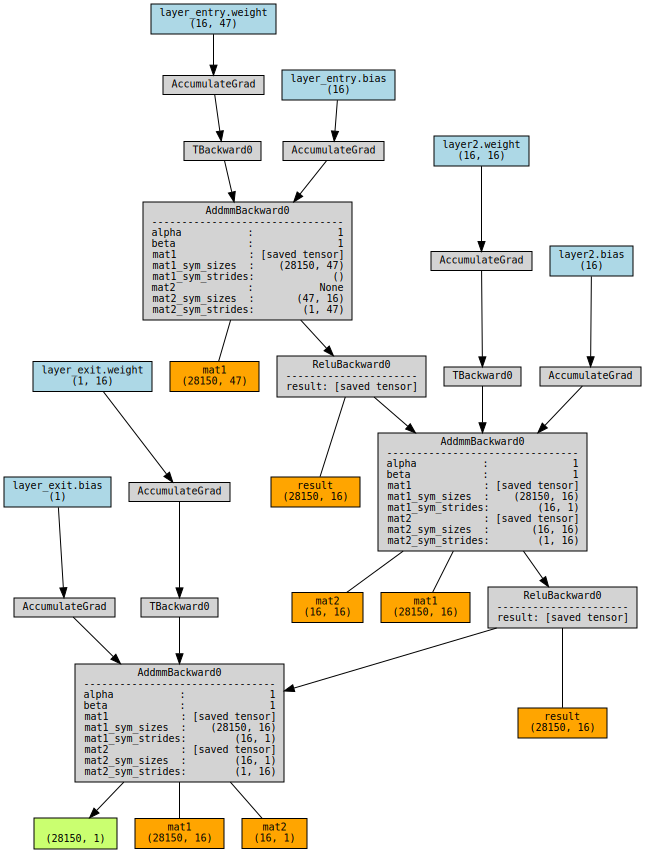

In [35]:
# Convert dataframes to dataset
class MyDataset(Dataset):
    def __init__(self, input_df, target_df):
        self.input_tensor = torch.tensor(input_df.values, dtype=torch.float32).to(device)
        self.target_tensor = torch.tensor(target_df.values, dtype=torch.float32).to(device)
    def __len__(self):
        return len(self.input_tensor) # Number of rows in our input dataset
    def __getitem__(self, idx):
        return self.input_tensor[idx], self.target_tensor[idx]
    def get_tensors(self):
        return self.input_tensor, self.target_tensor

# Model definition
class MyModel(nn.Module):
    def __init__(self, in_features):
        super(MyModel, self).__init__()
        hidden_dim = 16 # start smaller than the input dimension size and larger than the output dimension size
        self.layer_entry = nn.Linear(in_features, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        # self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_exit = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = nn.functional.relu(self.layer_entry(x))
        x = nn.functional.relu(self.layer2(x))
        # x = nn.functional.relu(self.layer3(x))
        x = self.layer_exit(x)
        return x

dataset = MyDataset(features_df, target_df)
model = MyModel(input_size).to(device)
input_tensor, target_tensor = dataset.get_tensors()
make_dot(model(input_tensor), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [36]:
# Training Tuning Parameters
batch_size = 64
learning_rate = 0.000001
num_epochs = 350
# Choose the best loss and optimizer functions
criterion = nn.L1Loss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Split the data and setup the data loaders
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(f'Training Size = {train_size}')
print(f'Test Size = {test_size}')

Training Size = 22520
Test Size = 5630


Epoch 35 (10%), Loss: 1052481
Epoch 70 (20%), Loss: 485279
Epoch 105 (30%), Loss: 290519
Epoch 140 (40%), Loss: 184614
Epoch 175 (50%), Loss: 106623
Epoch 210 (60%), Loss: 43449
Epoch 245 (70%), Loss: 9539
Epoch 280 (80%), Loss: 7743
Epoch 315 (90%), Loss: 6378
Epoch 350 (100%), Loss: 5308


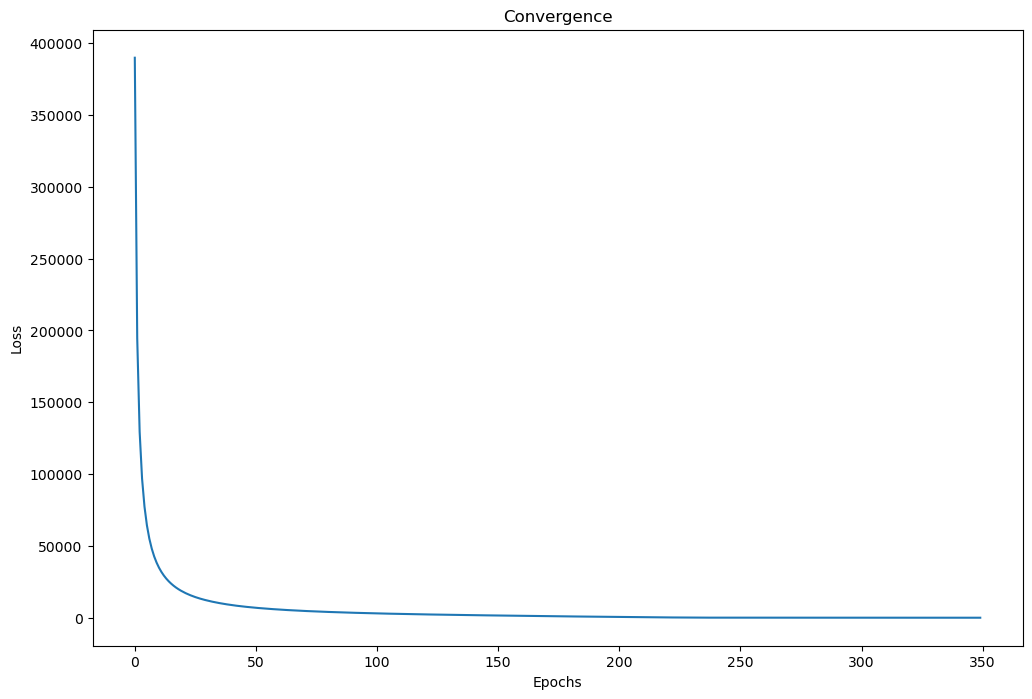

In [37]:
# Train the model and plot convergence
def train(train_dataloader, test_dataloader, model, criterion, optimizer, num_epochs):
    plot_losses = []
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            input_tensor, target_tensor = data
            optimizer.zero_grad()
            output_tensor = model(input_tensor)
            loss = criterion(output_tensor, target_tensor)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                input_tensor, target_tensor = data
                output_tensor = model(input_tensor)
                loss = criterion(output_tensor, target_tensor)
                total_loss += loss.item()
        if epoch % (num_epochs/20) == 0:
            percentComplete = epoch/num_epochs*100
            print(f'Epoch {epoch} ({percentComplete:.0f}%), Loss: {total_loss/epoch*100:.0f}') # *100 to add some precision
        plot_losses.append(total_loss/epoch)
    return plot_losses

plot_losses = train(train_dataloader, test_dataloader, model, criterion, optimizer, num_epochs)
path = '../outputs/housing_growth_model.pth'
torch.save(model, path)
plt.figure(figsize=(12,8))
plt.title("Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(plot_losses)

In [38]:
saved_model = torch.load(path)

def getAccuracyPercentage(list1, list2):
    mean_abs_diff = np.mean(np.abs(list1 - list2))
    mean_orig = np.mean([list1, list2])
    return 100 - mean_abs_diff / mean_orig * 100

# Test the model's accuracy
saved_model.eval()
input_tensor, target_tensor = test_dataset.dataset.get_tensors()
with torch.no_grad():
    y_prediction_tensor = saved_model(input_tensor)
    y_predicted = y_prediction_tensor.detach().cpu().numpy()
    y_actual = target_tensor.detach().cpu().numpy()
    accuracy_percent = getAccuracyPercentage(y_predicted, y_actual)
    print(f"Test Accuracy: {accuracy_percent:>0.1f}%")

Test Accuracy: 95.1%


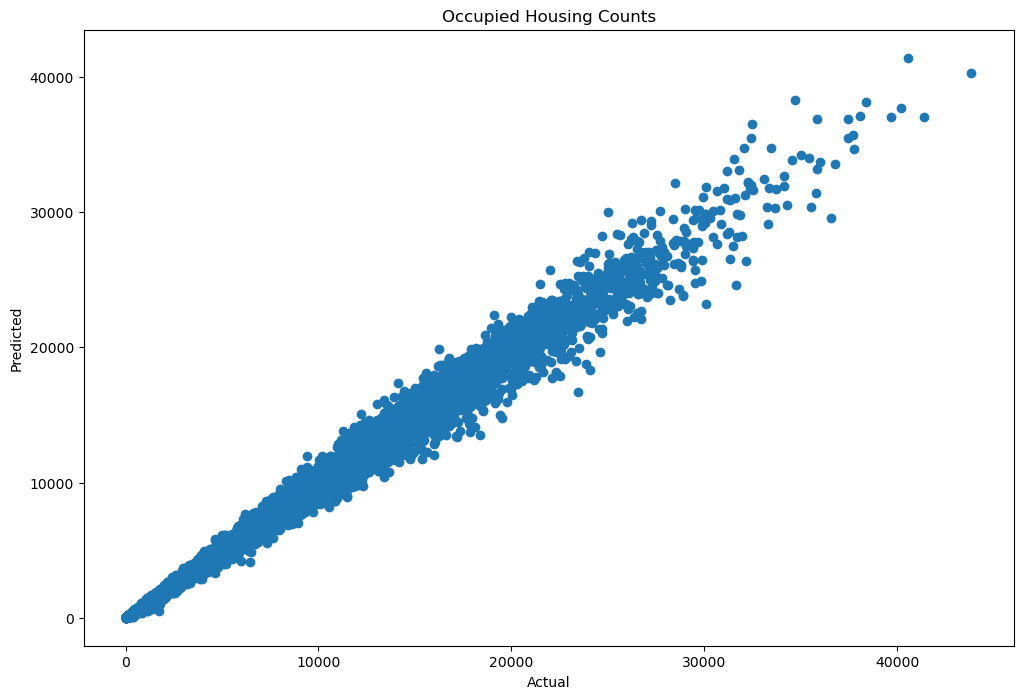

In [39]:
# Scatter plot results to show accuracy (45% upward, rightward slope scatter plot)
plt.figure(figsize=(12,8))
plt.scatter(y_predicted, y_actual)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Occupied Housing Counts")
plt.show()

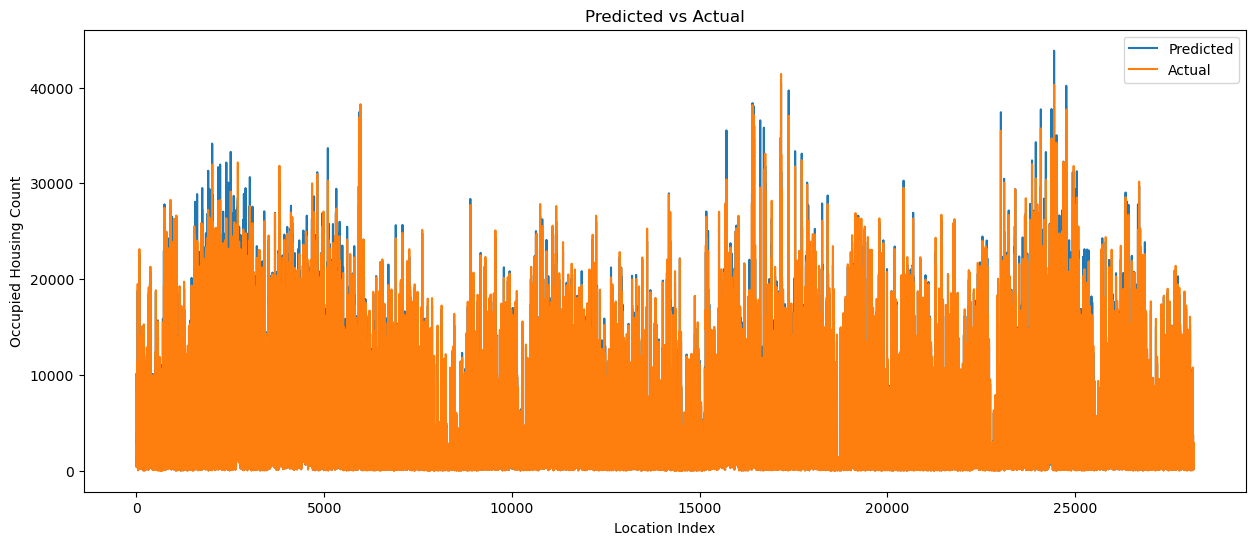

In [40]:
# Show accuracy by overlaying actual vs pridicted prices
# Orange on top helps underpriced stocks stand out
plt.figure(figsize=(15,6))
plt.plot(y_predicted, color='#1f77b4', label='Predicted')
plt.plot(y_actual, color='#ff7f0e', label='Actual')
plt.title("Predicted vs Actual")
plt.xlabel("Location Index")
plt.ylabel("Occupied Housing Count")
plt.legend()
plt.show()

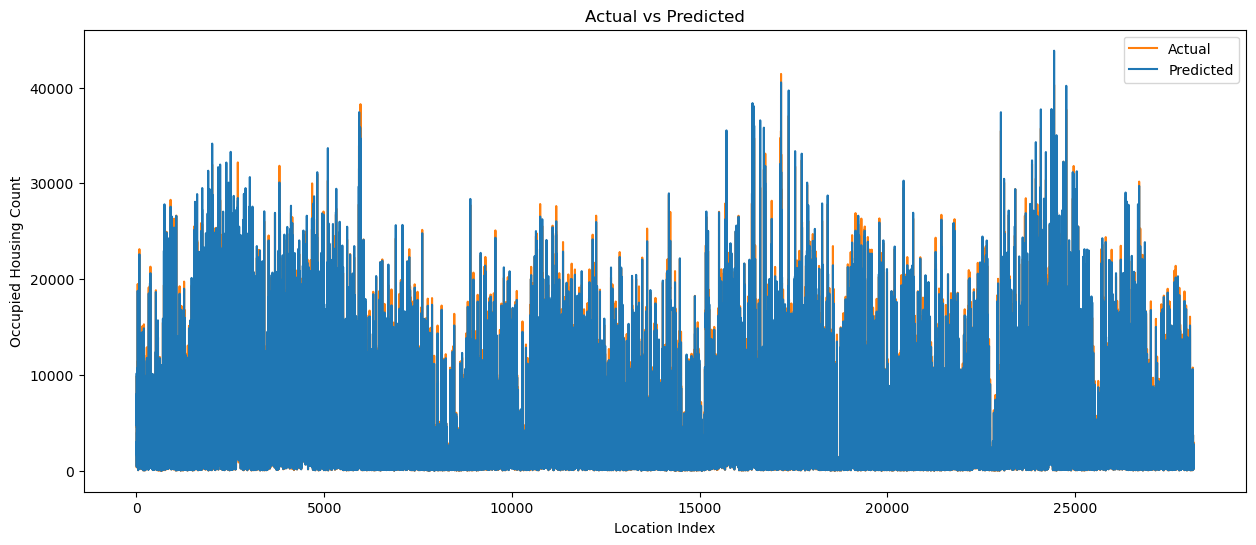

In [41]:
# Inverse the plot so blue is on top.  This helps high overpriced homes stand out
plt.figure(figsize=(15,6))
plt.plot(y_actual, color='#ff7f0e', label='Actual')
plt.plot(y_predicted, color='#1f77b4', label='Predicted')
plt.title("Actual vs Predicted")
plt.xlabel("Location Index")
plt.ylabel("Occupied Housing Count")
plt.legend()
plt.show()

In [42]:
# Run predictions for the full dataset
saved_model.eval()
input_tensor, target_tensor = test_dataset.dataset.get_tensors()
with torch.no_grad():
    y_prediction_tensor = saved_model(input_tensor)
    y_predicted = y_prediction_tensor.detach().cpu().numpy()
    y_actual = target_tensor.detach().cpu().numpy()
    predicted_price_difference = (y_predicted - y_actual) / ((y_predicted + y_actual) / 2) * 100
    accuracy_percent = 100-abs(np.average(predicted_price_difference))
# Generate and save to disk a new table with both actual and predicted prices for just those stocks where the prices differ by over 10%
output_df = df.copy()
target_index = 7
output_df.insert(target_index+1, 'Predicted Occupied Housing Units', y_predicted.round())
output_df.insert(target_index+2, '% Difference', predicted_price_difference)
output_df.to_csv('../outputs/housing_growth.csv', index=False)
# Sort so the prices that are too low go to the top
output_df = output_df.sort_values(by='% Difference', ascending=False)
output_df.sample(10, ignore_index=True)
# output_df.head(10)

,State,State Abbreviated,City,Zip Code,Latitude,Longitude,Vacant Housing Units,Occupied Housing Units,Predicted Occupied Housing Units,% Difference,...,Household Income 5-9k,Household Income 10-14k,Household Income 15-19k,Household Income 20-24k,Household Income 25-34k,Household Income 35-49k,Household Income 50-74k,Household Income 75-99k,Household Income 100-149k,Household Income 150k+
0,Florida,FL,Gainesville,32609,29.7005,-82.3080,993.0,7463.0,7467.0,0.052439,...,383,756,456,427,974,1466,1360,627,473,283
1,Michigan,MI,Edwardsburg,49112,41.7913,-86.0263,471.0,4221.0,4124.0,-2.326864,...,54,161,165,146,432,593,740,525,682,624
2,Maryland,MD,Dickerson,20842,39.2126,-77.4199,63.0,661.0,682.0,3.196599,...,0,9,14,19,10,4,143,59,85,313
3,Virginia,VA,Gainesville,20155,38.8157,-77.6216,288.0,12052.0,12841.0,6.338827,...,64,79,121,59,297,503,1127,1587,2954,5006
4,Michigan,MI,Leonidas,49066,42.0294,-85.3497,25.0,256.0,254.0,-0.811224,...,9,7,24,23,13,37,63,40,20,14
5,Pennsylvania,PA,Philadelphia,19132,39.9954,-75.1698,3255.0,14384.0,13385.0,-7.194375,...,1221,1831,1365,1192,1883,1907,1723,811,712,447
6,Georgia,GA,Folkston,31537,30.8508,-82.0116,440.0,3270.0,3482.0,6.281932,...,282,102,357,174,280,424,693,317,387,107
7,Maryland,MD,Swanton,21561,39.4764,-79.2402,1438.0,1061.0,1101.0,3.713100,...,0,37,37,37,71,207,201,81,188,202
8,Texas,TX,Briscoe,79011,35.5855,-100.1679,62.0,88.0,99.0,11.279154,...,0,2,3,5,5,11,28,12,6,11
9,Ohio,OH,Brilliant,43913,40.2683,-80.6319,174.0,500.0,502.0,0.456621,...,8,42,23,28,70,102,124,20,37,23
